# Pyrion demo

This notebook demonstrates all major pyrion functionality.

In [1]:
# necessary imports
from pyrion import read_bed12_file, read_gene_data, read_fasta, GenomicInterval
from pyrion import TwoBitAccessor
from pyrion.core import DEFAULT_CANONIZER
from pyrion.core.nucleotide_sequences import SequenceType
from pyrion import read_chain_file
from pyrion.ops import project_intervals_through_chain, find_intersections
from pyrion.visualization import VisualizationWindow, TranscriptFeature, create_alignment_track
from pyrion.visualization import create_transcript_track
from pyrion.ops.chains import project_transcript_through_chain
from pyrion.ops.genes import extract_cds_sequence, extract_utr3_sequence, extract_utr5_sequence
from pyrion.ops import chains_to_arrays, transcripts_to_arrays
from collections import defaultdict

# Loading data

In [2]:
# load bed12, create a TranscriptsCollection object
hg38_annotation = read_bed12_file("test_data/hg38.v48.comprehensive.bed")
# load metadata (geneID to transcriptID, transcriptID to biotype, and geneID to name mappings) from a TSV file
# returns a GeneData object, containing 3 optional maps
hg38_annotation_data = read_gene_data("test_data/hg38.biomart.transcripts.data.tsv",
                              gene_column=1,  # since tsv may contain different column names in different order
                              transcript_id_column=2,  # specify here column numbers (or names)
                              gene_name_column=5,  # values are optional, read_gene_data will try to retrieve as many mappings as possible
                              transcript_type_column=6)
# this step is necessary to bind transcript data from hg38_annotation to the data retrieved from TSV
hg38_annotation.bind_gene_data(hg38_annotation_data)
print(hg38_annotation)

TranscriptsCollection: 385,669 transcripts across 25 chromosomes, 385,669 coding (100.0%)
Source: test_data/hg38.v48.comprehensive.bed


In [3]:
# loading genome alignments in .chain format is easy as
hg38_chr9_to_mm39_chr4_chains = read_chain_file("test_data/chains/hg38.chr9.mm39.chr4.chain")
print(hg38_chr9_to_mm39_chr4_chains)

GenomeAlignmentsCollection: 12,805 alignments across 1 target chroms, 1 query chroms, avg score: 64,609
Source: test_data/chains/hg38.chr9.mm39.chr4.chain


In [4]:
# TwoBitAccessor connects to a 2bit file and provides API for sequences extraction
hg38_chr9_accessor = TwoBitAccessor("test_data/two_bit/hg38.chr9.2bit")
mm39_chr4_accessor = TwoBitAccessor("test_data/two_bit/mm39.chr4.2bit")

print(hg38_chr9_accessor)
print(mm39_chr4_accessor)

TwoBitAccessor('test_data/two_bit/hg38.chr9.2bit', 1 chromosomes [chr9], 138.4Mb)
TwoBitAccessor('test_data/two_bit/mm39.chr4.2bit', 1 chromosomes [chr4], 156.9Mb)


# Transcripts canonization

In [5]:
# transcripts canonization
# pyrion supports canonizer functions, or you can provide geneID-principal transcript ID mapping
hg38_annotation.canonize_transcripts(DEFAULT_CANONIZER)

In [6]:
# extract genes by name; sometimes several genes may have the same name - so returns a list of all candidates
baat_gene = hg38_annotation.get_by_gene_name("BAAT")[0]
acnatp_gene = hg38_annotation.get_by_gene_name("ACNATP")[0]

print(baat_gene.__repr__())
print(acnatp_gene.__repr__())

Gene(id=ENSG00000136881.12, name=BAAT, chr9:101354181-101385400:-1, 5 transcripts, canonical=ENST00000259407.7)
Gene(id=ENSG00000227411.1, name=ACNATP, chr9:101334083-101339347:-1, 1 transcripts, canonical=ENST00000412284.1)


# Intersection basics

In [7]:
# find chains that intersect both genes
intersect_baat = hg38_chr9_to_mm39_chr4_chains.get_alignments_in_interval(baat_gene.canonical_transcript.transcript_interval)
print(f"Number of alignments intersecting BAAT gene: {len(intersect_baat)}")
intersect_acnatp = hg38_chr9_to_mm39_chr4_chains.get_alignments_in_interval(acnatp_gene.canonical_transcript.transcript_interval)
print(f"Number of alignments intersecting ACNATP gene: {len(intersect_acnatp)}")

intersect_both = set(intersect_baat).intersection(intersect_acnatp)
print(f"Number of alignments intersecting both genes: {len(intersect_both)}")

for chain in intersect_both:
    print(chain)

Number of alignments intersecting BAAT gene: 9
Number of alignments intersecting ACNATP gene: 7
Number of alignments intersecting both genes: 2
GenomeAlignment(id=20, score=411,413,821, T=chr9:27,325,074-120,726,664:+ -> Q=chr4:34,948,948-70,461,583:+, 466087 blocks)
GenomeAlignment(id=2188, score=318,522, T=chr9:101,320,361-101,371,415:+ -> Q=chr4:49,327,911-49,451,117:+, 302 blocks)


# Visualization basics

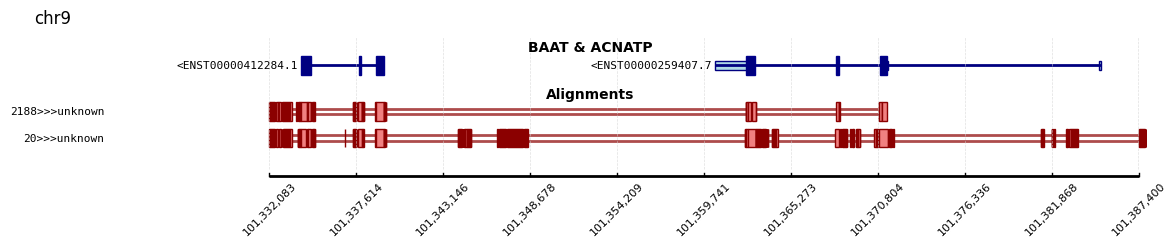

In [8]:
# sample visualization
# I am sorry that visualizations are not that nice as they could've been
# Planning to rework them in future releases

show_interval = GenomicInterval("chr9", acnatp_gene.start - 2000, baat_gene.end + 2000)
window = VisualizationWindow(show_interval)

window.add_track(create_transcript_track("BAAT & ACNATP", [baat_gene.canonical_transcript, acnatp_gene.canonical_transcript]))
window.add_track(create_alignment_track("Alignments", intersect_both))
window.show()

# Liftover chains sample

In [9]:
# chain liftover sample (for 1 transcript - not very efficient)
baat_liftover_20 = project_transcript_through_chain(baat_gene.canonical_transcript, hg38_chr9_to_mm39_chr4_chains.get_by_chain_id(20))
baat_liftover_2188 = project_transcript_through_chain(baat_gene.canonical_transcript, hg38_chr9_to_mm39_chr4_chains.get_by_chain_id(2188))
acnatp_liftover_20 = project_transcript_through_chain(acnatp_gene.canonical_transcript, hg38_chr9_to_mm39_chr4_chains.get_by_chain_id(20))
acnatp_liftover_2188 = project_transcript_through_chain(acnatp_gene.canonical_transcript, hg38_chr9_to_mm39_chr4_chains.get_by_chain_id(2188))

print(baat_liftover_20)
print(baat_liftover_2188)
print(acnatp_liftover_20)
print(acnatp_liftover_2188)

chr4:49487806-49510808:+ (chain_20_transcript_ENST00000259407.7)
chr4:49445320-49451117:+ (chain_2188_transcript_ENST00000259407.7)
chr4:49447307-49451106:+ (chain_20_transcript_ENST00000412284.1)
chr4:49380096-49383548:+ (chain_2188_transcript_ENST00000412284.1)


In [10]:
# find mouse transcripts in these regions
mouse_transcripts = read_bed12_file("test_data/mm39.vM37.comprehensive.bed")
print(mouse_transcripts)

TranscriptsCollection: 278,299 transcripts across 22 chromosomes, 278,299 coding (100.0%)
Source: test_data/mm39.vM37.comprehensive.bed


In [11]:
for interval in [baat_liftover_20, baat_liftover_2188, acnatp_liftover_20, acnatp_liftover_2188]:
    mm39_intersects = mouse_transcripts.get_transcripts_in_interval(interval)
    print(f"Transcripts intersecting {interval}")
    print([t.id for t in mm39_intersects])

Transcripts intersecting chr4:49487806-49510808:+ (chain_20_transcript_ENST00000259407.7)
['ENSMUST00000262144.1', 'ENSMUST00000262145.1', 'ENSMUST00000262146.1', 'ENSMUST00000262148.1', 'ENSMUST00000262147.1', 'ENSMUST00000043056.9', 'ENSMUST00000166036.2', 'ENSMUST00000306766.1']
Transcripts intersecting chr4:49445320-49451117:+ (chain_2188_transcript_ENST00000259407.7)
['ENSMUST00000107697.2', 'ENSMUST00000095086.3', 'ENSMUST00000135976.2']
Transcripts intersecting chr4:49447307-49451106:+ (chain_20_transcript_ENST00000412284.1)
['ENSMUST00000107697.2', 'ENSMUST00000095086.3', 'ENSMUST00000135976.2']
Transcripts intersecting chr4:49380096-49383548:+ (chain_2188_transcript_ENST00000412284.1)
['ENSMUST00000081541.9', 'ENSMUST00000107698.8', 'ENSMUST00000125123.2', 'ENSMUST00000139564.2']


# Sequences basics

In [12]:
# to extract sequences use transcript + sequence accessor (2bit, fasta, fasta+fai)
baat_cds = extract_cds_sequence(baat_gene.canonical_transcript, hg38_chr9_accessor)
print(f"BAAT CDS: {baat_cds}")
baat_3utr = extract_utr3_sequence(baat_gene.canonical_transcript, hg38_chr9_accessor)
baat_5utr = extract_utr5_sequence(baat_gene.canonical_transcript, hg38_chr9_accessor)
print(f"BAAT 3'UTR: {baat_3utr}")
print(f"BAAT 5'UTR: {baat_5utr}")

baat_proten = baat_cds.to_amino_acids()
print(f"Translated protein: {baat_proten}")

BAAT CDS: ATGATCCAGTTGACAGCTACCCCTGTGAGTGCACTTGTTGATGAGCCAGTGCATATCCGAGCTACAGGCCTGATTCCCTTTCAGATGGTGAGTTTTCAGGCATCACTGGAAGATGAAAACGGAGACATGTTTTATTCTCAAGCCCACTATAGGGCCAATGAATTCGGTGAGGTGGACCTGAATCATGCTTCTTCACTTGGAGGGGATTATATGGGAGTCCACCCCATGGGTCTCTTCTGGTCTCTGAAACCTGAAAAGCTATTAACAAGACTGTTGAAAAGAGATGTGATGAATAGGCCTTTCCAGGTCCAAGTAAAACTTTATGACTTAGAGTTAATAGTGAACAATAAAGTTGCCAGTGCTCCAAAGGCCAGCCTGACTTTGGAGAGGTGGTATGTGGCACCTGGTGTCACACGAATTAAGGTTCGAGAAGGCCGCCTTCGAGGAGCTCTCTTTCTCCCTCCAGGAGAGGGTCTCTTCCCAGGGGTAATTGATTTGTTTGGTGGTTTGGGTGGGCTGCTTGAATTTCGGGCCAGCCTCCTAGCCAGTCGTGGCTTCGCCTCCTTGGCCTTGGCTTACCATAACTATGAAGACCTGCCCCGCAAACCAGAAGTAACAGATTTGGAATATTTTGAGGAGGCTGCCAACTTTCTCCTGAGACATCCAAAGGTCTTTGGCTCAGGCGTTGGGGTAGTCTCTGTATGTCAAGGAGTACAGATTGGACTATCTATGGCTATTTACCTAAAGCAAGTCACAGCCACGGTACTTATTAATGGGACCAACTTTCCTTTTGGCATTCCACAGGTATATCATGGTCAGATCCATCAGCCCCTTCCCCATTCTGCACAATTAATATCCACCAATGCCTTGGGGTTACTAGAGCTCTATCGCACTTTTGAGACAACTCAAGTTGGGGCCAGTCAATATTTGTTTCCTATTGAAGAGGCCCAGGGGCAATTCCTCTTCATTGTAGGAGAAGGTGATAAGACT

# Intersections, a bit more advanced.

Core data structures store intervals data as 2D numpy arrays [(start, end) ... ].
So, massive intersection operations can benefit from it the power of vectorized numpy operations.

In [13]:
chrom_transcripts = hg38_annotation.get_by_chrom("chr9")

chain_arr, chain_id_arr = chains_to_arrays(hg38_chr9_to_mm39_chr4_chains)  # convert to 2D array for fast intersections
transcript_arr, transcript_id_arr = transcripts_to_arrays(chrom_transcripts)  # same for transcripts, IDs array will be needed to map everything back

intersections = find_intersections(chain_arr, transcript_arr, chain_id_arr, transcript_id_arr)
print(f"Found intersections vs trancsripts for {len(intersections)} chains")

for chain_id, intersection_data in intersections.items():
    print(chain_id, intersection_data)
    break

# intersection data provides tuples of (transrcipt_ID, intersection size)

Found intersections vs trancsripts for 11294 chains
1992588 [(np.str_('ENST00000642633.1'), np.int64(172)), (np.str_('ENST00000837655.1'), np.int64(172)), (np.str_('ENST00000646046.1'), np.int64(166))]


# Fasta examples

In [14]:
arf5_fasta = read_fasta("test_data/fasta/ARF5.fasta", SequenceType.DNA)
print(arf5_fasta)

{'REFERENCE': NucleotideSequence('ATGGGCCTCACCGTGTCCGCGCTCTTTTCGCGGATCTTCGGGAAGAA...', len=720, type=DNA, metadata=True), 'vs_HLaciJub2\tENST00000000233.ARF5.13': NucleotideSequence('ATGGGCCTCACCGTGTCCGCGCTCTTTTCGCGGATCTTCGGGAAGAA...', len=720, type=DNA, metadata=True), 'vs_tupChi1\tENST00000000233.ARF5.355': NucleotideSequence('ATGGGCCTCACCGTGTCCGCGCTCTTTTCGCGGATCTTCGGGAAGAA...', len=720, type=DNA, metadata=True), 'vs_triMan1\tENST00000000233.ARF5.74': NucleotideSequence('ATGGGCCTCACCGTGTCCGCGCTCTTCTCGCGGATCTTCGGGAAGAA...', len=720, type=DNA, metadata=True), 'vs_tarSyr2\tENST00000000233.ARF5.1630977': NucleotideSequence('ATGGGCCTCACCATCTCCTCTCTCTTCTCCCGCCTCTTCGGCAAGAA...', len=720, type=DNA, metadata=True), 'vs_susScr11\tENST00000000233.ARF5.15': NucleotideSequence('ATGGGCCTCACGGTGTCCGCGCTCTTTTCGCGGATCTTCGGGAAGAA...', len=720, type=DNA, metadata=True), 'vs_speTri2\tENST00000000233.ARF5.216': NucleotideSequence('ATGGGCCTCACCGTGTCCGCGCTCTTTTCGCGGATCTTCGGGAAGAA...', len=720, type=DNA, me

In [15]:
reference_sequence = arf5_fasta.get("REFERENCE")
print(reference_sequence.to_amino_acids())

MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTIPTIGFNVETVEYKNICFTVWDVGGQDKIRPLWRHYFQNTQGLIFVVDSNDRERVQESADELQKMLQEDELRDAVLLVFANKQDMPNAMPVSELTDKLGLQHLRSRTWYVQATCATQGTGLYDGLDWLSHELSKRX


In [16]:
# let's try introducing a frameshift
reference_codons = reference_sequence.to_codons()
reference_codons.remove_gaps()
print("without_frameshift:")
print(reference_codons)
print(reference_codons.translate())

print("Let's insert frameshift to position 100 (shown as !):")
reference_codons.insert_frameshift(100)
print(reference_codons)
print(reference_codons.translate())
print(reference_codons.get_codons())

without_frameshift:
ATGGGCCTCACCGTGTCCGCGCTCTTTTCGCGGATCTTCGGGAAGAAGCAGATGCGGATTCTCATGGTTGGCTTGGATGCGGCTGGCAAGACCACAATCCTGTACAAACTGAAGTTGGGGGAGATTGTCACCACCATCCCAACCATAGGCTTCAATGTAGAAACAGTGGAATATAAGAACATCTGTTTCACAGTCTGGGACGTGGGAGGCCAGGACAAGATTCGGCCTCTGTGGCGGCACTACTTCCAGAACACTCAGGGCCTCATCTTTGTGGTGGACAGTAATGACCGGGAGCGGGTCCAAGAATCTGCTGATGAACTCCAGAAGATGCTGCAGGAGGACGAGCTGCGGGATGCAGTGCTGCTGGTATTTGCCAACAAGCAGGACATGCCCAACGCCATGCCCGTGAGCGAGCTGACTGACAAGCTGGGGCTACAGCACTTACGCAGCCGCACGTGGTATGTCCAGGCCACCTGTGCCACCCAAGGCACAGGTCTGTACGATGGTCTGGACTGGCTGTCCCACGAGCTGTCAAAGCGCNNN
MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTIPTIGFNVETVEYKNICFTVWDVGGQDKIRPLWRHYFQNTQGLIFVVDSNDRERVQESADELQKMLQEDELRDAVLLVFANKQDMPNAMPVSELTDKLGLQHLRSRTWYVQATCATQGTGLYDGLDWLSHELSKRX
Let's insert frameshift to position 100 (shown as !):
ATGGGCCTCACCGTGTCCGCGCTCTTTTCGCGGATCTTCGGGAAGAAGCAGATGCGGATTCTCATGGTTGGCTTGGATGCGGCTGGCAAGACCACAATCCT!GTACAAACTGAAGTTGGGGGAGATTGTCACCACCATCCCAACCATAGGCTTCAATGTAGAAACAGTGGAATATAAGAACATCTGTTTCACAGTCTGGG